# Simulate Missing Neural Signals

## Create partial dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.decomposition import PCA
from scipy import linalg
import seaborn as sns
import time


import globals as glb
import plot_utils as putils
from data_loader import RecordingData, SpontaneousRecordingData
from data_sampler import MissingTraceSampler, PartialSpontRecordingData
from recover_fconnectivity import *
import evals
from main import *


%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/Mike/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Mike/miniconda3/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Load full data

In [2]:
DATA_DIR = "../Data/"
spont_mat = scipy.io.loadmat(DATA_DIR + "dbspont.mat").get("db")[0]  # 9 datasets of recordings

SIDX = 0
spont0_fp = DATA_DIR + "_".join(["spont", spont_mat[SIDX][glb.SESSION_NAME][0], spont_mat[SIDX][glb.REC_DATE][0]])
spont_data0 = SpontaneousRecordingData(data_fp=spont0_fp)

spont_data0.display_field_shapes()

Removing 1 all-zero columns
neuron counts: 11983
layer counts: 9
Layer 0: 1131 neurons
Layer 1: 1183 neurons
Layer 2: 1218 neurons
Layer 3: 1321 neurons
Layer 4: 1415 neurons
Layer 5: 1471 neurons
Layer 6: 1418 neurons
Layer 7: 1440 neurons
Layer 8: 1386 neurons
timestamp counts 21054
running speed (21054, 1)
face motion mask (240, 320, 1000)
face motion svd (21054, 1000)
avg frame (240, 320)
pupil area (21054, 1)
pupil com (21054, 2)
eye motion svd (21054, 500)
whisker motion mask (216, 304, 500)
whisker motion SVD (21054, 500)


In [3]:
# subset the dataset in all three dimensions
# - select layer 0,1,2,3,4,5
# - consider only timestamp from 100 to 1000
# - consider horizontal region of ratio 0.1 - 0.3 w.r.t. the original plane
partial_spont0 = PartialSpontRecordingData(dataset=spont_data0, layers=[0,1,2,3], 
                                           start_timepoint=100, end_timepoint=1100, 
                                           x_range=(0.2, 0.6), y_range=(0.2, 0.6), ratio=True)

In [4]:
partial_spont0.display_field_shapes()

neuron counts: 806
layer counts: 4
Layer 0: 172 neurons
Layer 1: 196 neurons
Layer 2: 213 neurons
Layer 3: 225 neurons
timestamp counts 1000
running speed (1000, 1)
face motion mask (240, 320, 1000)
face motion svd (1000, 1000)
avg frame (240, 320)
pupil area (1000, 1)
pupil com (1000, 2)
eye motion svd (1000, 500)
whisker motion mask (216, 304, 500)
whisker motion SVD (1000, 500)


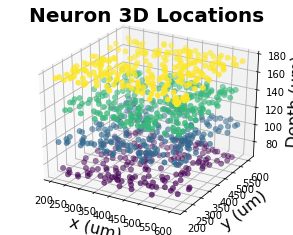

In [5]:
plt.rcParams['figure.figsize'] = [5, 4]
partial_spont0.display_neuron_3d()  # TODO: why is this so small???

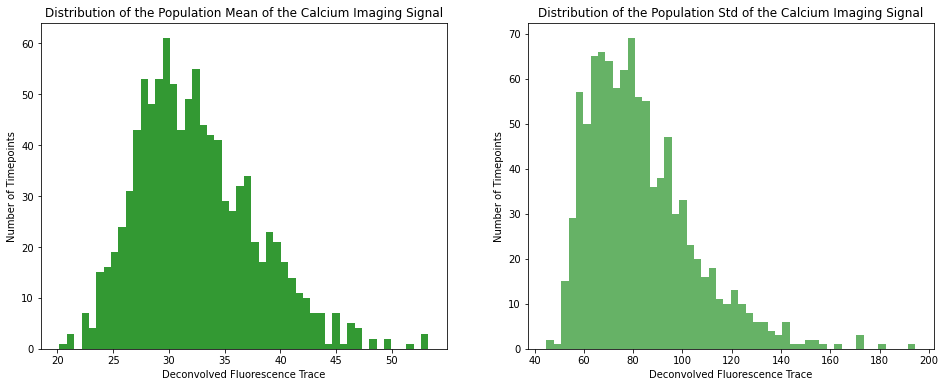

In [6]:
partial_spont0.display_fsp_distribution_all_time()

In [7]:
print(partial_spont0.run_speed.shape)
print(partial_spont0.pupil_area.shape)

(1000, 1)
(1000, 1)


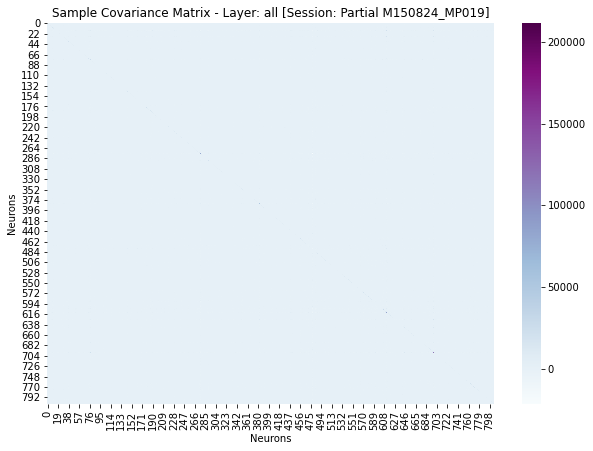

array([[ 1.93064133e+03,  6.74665073e+01,  8.87521750e+01, ...,
         1.76181049e+02, -1.35903432e+02,  1.04157294e+02],
       [ 6.74665073e+01,  6.02612615e+02,  4.73943095e+00, ...,
        -5.57281256e+01,  1.57917467e+01,  4.51251869e+01],
       [ 8.87521750e+01,  4.73943095e+00,  1.29360629e+03, ...,
        -1.97862535e+01, -1.09926635e+02,  2.15219551e+01],
       ...,
       [ 1.76181049e+02, -5.57281256e+01, -1.97862535e+01, ...,
         8.39627229e+03,  1.05295122e+02, -9.93639270e+01],
       [-1.35903432e+02,  1.57917467e+01, -1.09926635e+02, ...,
         1.05295122e+02,  4.43707089e+03,  1.62520429e+02],
       [ 1.04157294e+02,  4.51251869e+01,  2.15219551e+01, ...,
        -9.93639270e+01,  1.62520429e+02,  4.13284071e+03]])

In [8]:
partial_spont0.sample_covariance_matrix(display=True)

## Sample Missing Data by Layers (continuous)

In [9]:
sampler = MissingTraceSampler()

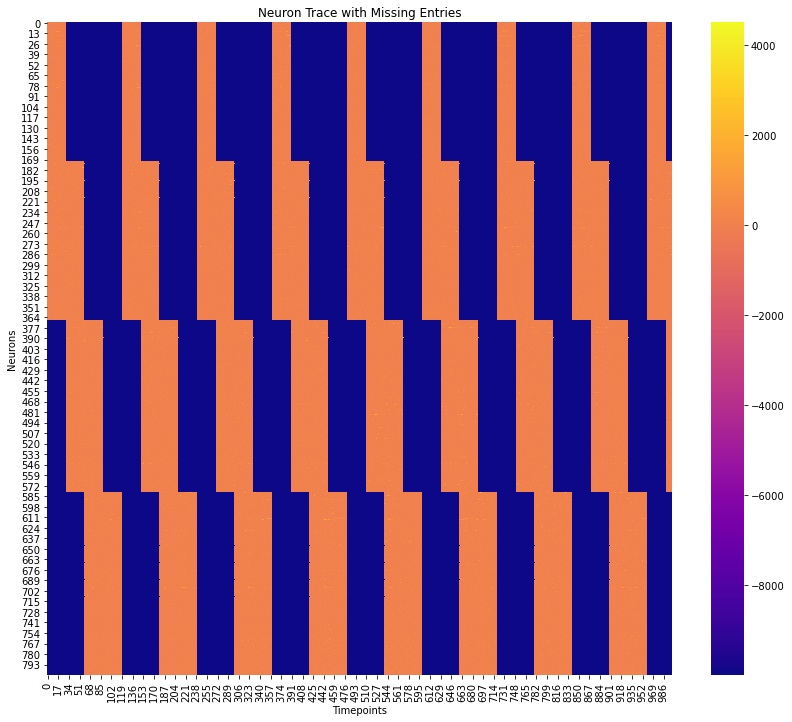

In [10]:
plt.rcParams['figure.figsize'] = [14, 12]
# adjust layer_stride to allow for overlaps in two partial observation sections
missing_fsp_cont = sampler.missing_fsp_consecutive_layers(dataset=partial_spont0, sim_timestamps=30, sim_layer_size=2, 
                                                          layer_stride=1, display=True)


## Sample Missing Data by Layers (interleaving)

In [11]:
sampler = MissingTraceSampler()

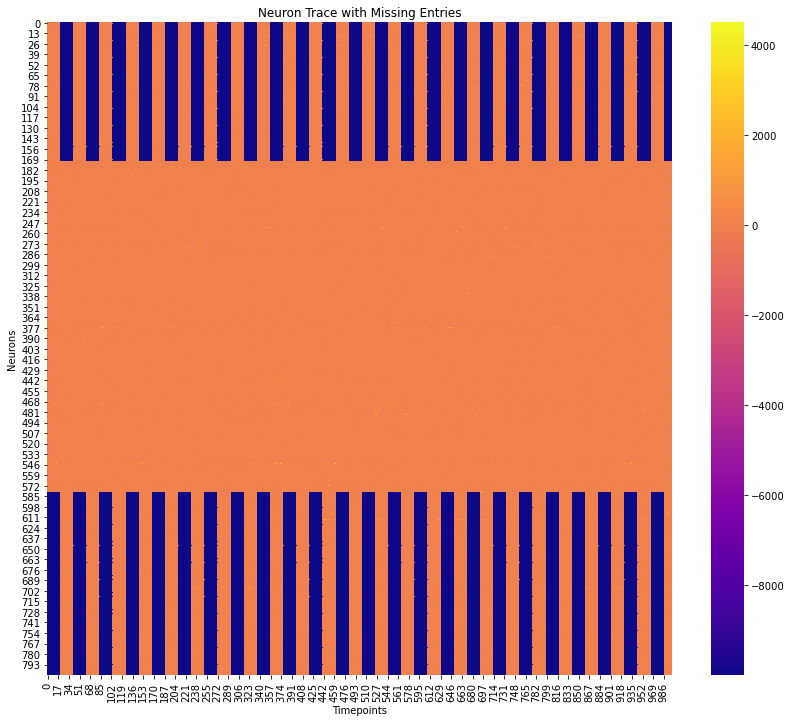

In [12]:
missing_fsp_cont = sampler.missing_fsp_interleaving_layers(dataset=partial_spont0, sim_timestamps=21, 
                                                           sim_layer_size=3, display=True)


## Experiments
### Consecutive layers within each simultaneous neuron blocks

In [13]:
#   sessions: list
#   time_range: tuple
#   sim_timestamps: int
#   auxi_mask: list = None
#   layersOI: np.ndarray = np.arange(4)
#   xrange: tuple = (0.1, 0.3)
#   yrange: tuple = (0.1, 0.3)
#   ratio: bool = True
#   init_useCorr: bool = True
#   sim_layer_size: int = 1
#   layer_stride: int = 1
#   psd_corrector: str = glb.NEWTON
#   full_glasso_alpha: float = None
#   full_Kfolds: int = None
#   full_gamma: float = 0
#   glasso_alpha: float = None
#   Kfolds: int = None
#   gamma: float = 0
#   rec_model: str = glb.LINEAR_REG
#   edge_types: int = 2
#   edge_cutoff_tol: float = 1e-8
#   edge_cutoff_qt: float = 0.05

# session 0, 2, 3, 7
# tuning_curve predictor failed: 1, 4, 5 (TODO: debug this, might relate to binrange for each auxi info)
fcr_config = FCRecoveryConfig(sessions=[1,4,6], time_range=(100, 1100), sim_timestamps=30, auxi_mask=None, 
                              layersOI=np.arange(4), xrange=(0.2, 0.6), yrange=(0.2, 0.6), 
                              sim_layer_size=1, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                              full_glasso_alpha=0.1, glasso_alpha=0.1, rec_model=glb.LINEAR_REG, 
                              edge_types=2, edge_cutoff_tol=1e-8)

In [14]:
session2res_consec = diff_session_diff_missing_by_layers(fcr_config, consecutive=True)


Total: 9 datasets
Removing 1 all-zero columns
Removing 7 zero-variance neurons

Session 1 loaded! M160907_MP028
Start, end time:  100 1100
Number of neurons:  735


/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:211: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/Mike/miniconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:261: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 6.304e-04
  warnings.warn('graphical_lasso: did not converge after '
/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/utils.py:85: RuntimeWarning: Mean of empty slice
  avg_tuning_curve.append(np.nanmean(fsp_ibin, axis=1))


Session 1: Auxiliary Matrix Created!
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Session 1 Auxiliary Info Comparison Finished!

Removing 1 all-zero columns

Session 4 loaded! M161025_MP030


/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:211: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Start, end time:  100 1100
Number of neurons:  708
Sample Correlation Matrix is positive definite!


/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/utils.py:85: RuntimeWarning: Mean of empty slice
  avg_tuning_curve.append(np.nanmean(fsp_ibin, axis=1))


Session 4: Auxiliary Matrix Created!
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Session 4 Auxiliary Info Comparison Finished!

Removing 3 zero-variance neurons

Session 6 loaded! M170714_MP032
Start, end time:  100 1100
Number of neurons:  693


/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:211: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/utils.py:85: RuntimeWarning: Mean of empty slice
  avg_tuning_curve.append(np.nanmean(fsp_ibin, axis=1))


Session 6: Auxiliary Matrix Created!
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Session 6 Auxiliary Info Comparison Finished!



In [15]:
for k in session2res_consec.keys():
    print("\n\nSession: %s" % k)
    print("Number of neurons: ", session2res_consec[k]['missing_fsp'].shape[0])
    print(session2res_consec[k]['result'])



Session: M160907_MP028
Number of neurons:  735
Ahat                 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
acc                  0.9036386216611986
auxi_sigma_corr      0.38222581470524736
auxi_sigma_err       0.07640716375657376
f1                   0.09849824853466514
fcRec_result         FCRecoveryResult(auxi_sigma=array([[ 1.        ,  0.03039377,  0.03530733, ..., -0.00609612,
        -0.02014541,  0.00737784],
       [ 0.03039377,  1.        ,  0.06225482, ...,  0.00140091,
        -0.02101754, -0.03111236],
       [ 0.03530733,  0.06225482,  1.        , ...,  0.04848271,
         0.03432367, -0.05968908],
       ...,
       [-0.00609612,  0.00140091,  0.04848271, ...,  1.        ,
         0.01774541,  0.00877529],
       [-0.02014541, -0.02101754,  0.03432367, ...,  0.01774541,
         1.        , -0.0138599 ],
       [ 0.00737784, -0.03111236, -0.05968908, ...

## Vary different auxiliary info 

In [16]:
fcr_config = FCRecoveryConfig(sessions=[7], time_range=(100, 1100), sim_timestamps=30, auxi_mask=None, 
                              layersOI=np.arange(4), xrange=(0.2, 0.6), yrange=(0.2, 0.6), 
                              sim_layer_size=1, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                              full_glasso_alpha=0.1, glasso_alpha=0.1, rec_model=glb.LINEAR_REG, 
                              edge_types=2, edge_cutoff_tol=1e-8)

In [17]:
auxi_masks = [[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],
              [1,1,1,1,1]] # 

In [18]:
session2res_auxi = diff_session_diff_auxi(fcr_config, auxi_masks, consecutive=True)


9 datasets to loaded
Removing 4 zero-variance neurons

Session 7 loaded! M170717_MP033
start, end time:  100 1100


/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:211: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/utils.py:85: RuntimeWarning: Mean of empty slice
  avg_tuning_curve.append(np.nanmean(fsp_ibin, axis=1))


Session 7: Auxiliary Matrix Created!
Auxi_mats_to_use:  (1, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Auxi_mats_to_use:  (1, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Auxi_mats_to_use:  (1, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Auxi_mats_to_use:  (1, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Auxi_mats_to_use:  (1, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Auxi_mats_to_use:  (5, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Session 7 Auxiliary Info Comparison Finished!



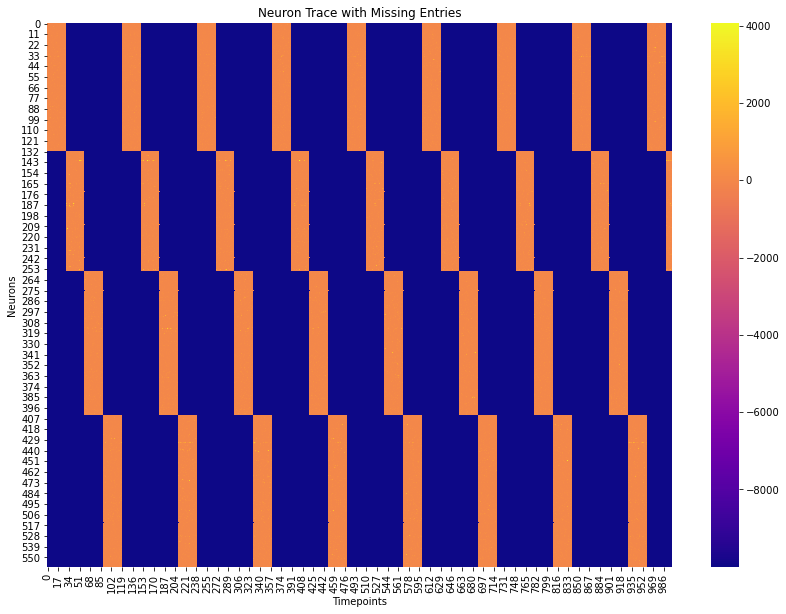

In [19]:
plt.rcParams['figure.figsize'] = [14, 10]
putils.display_missing_fsp(session2res_auxi['M170717_MP033']['missing_fsp'])


Optimal Lambda for full data:  None


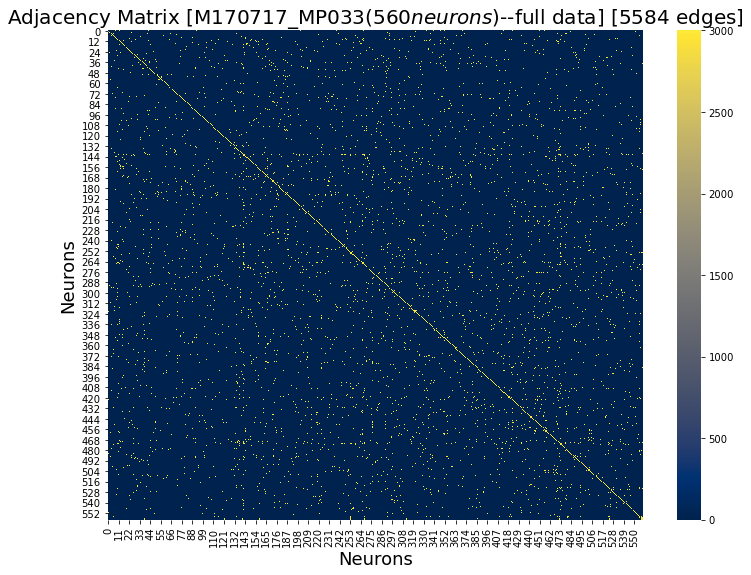

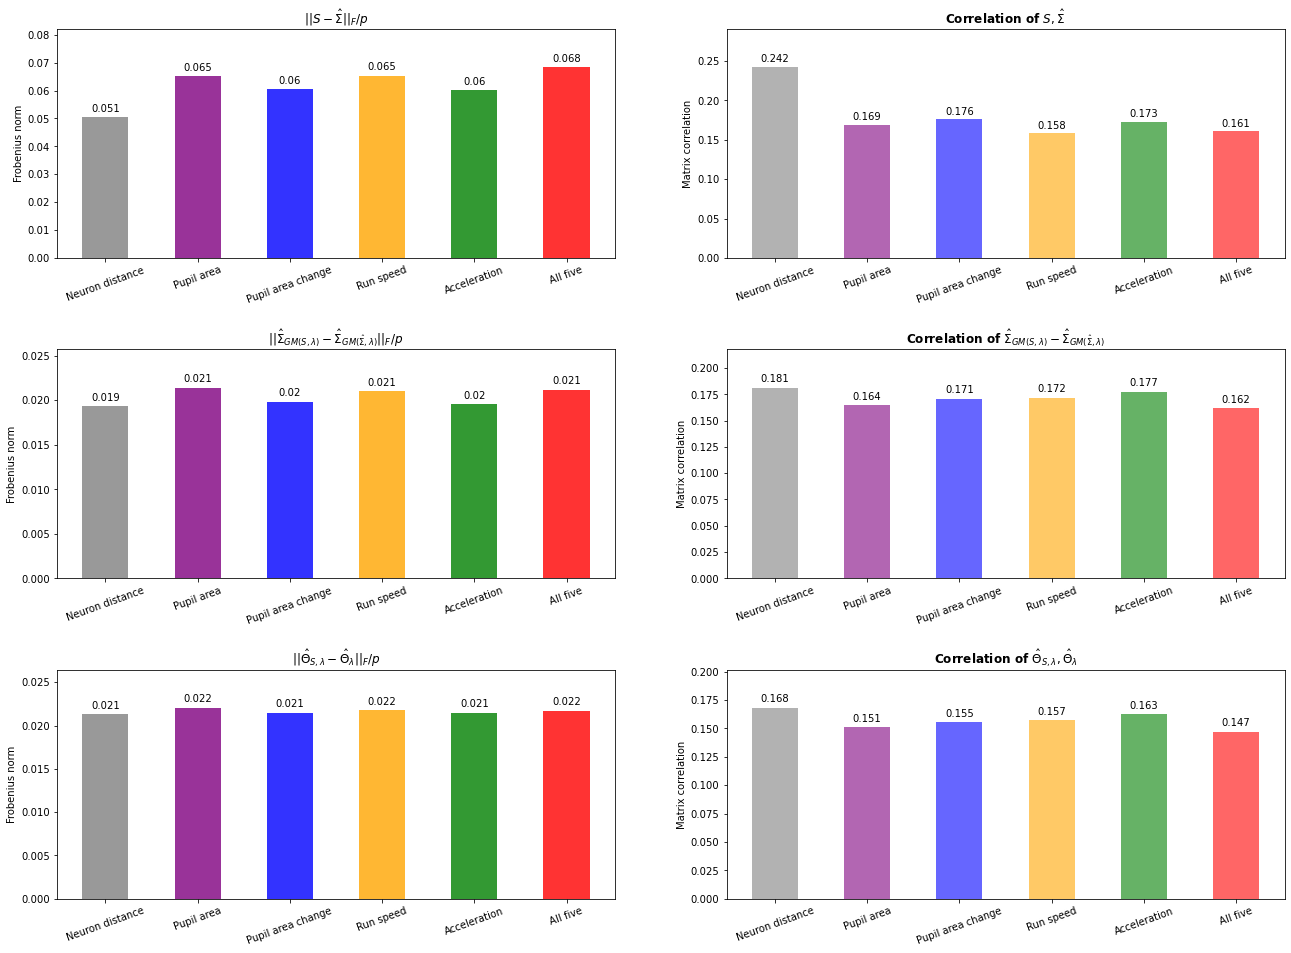

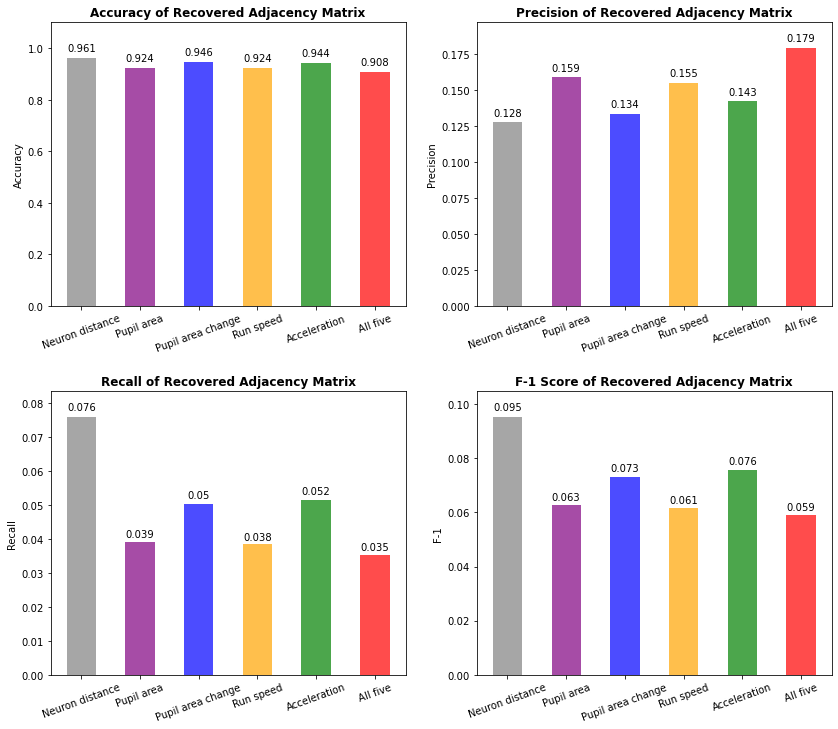

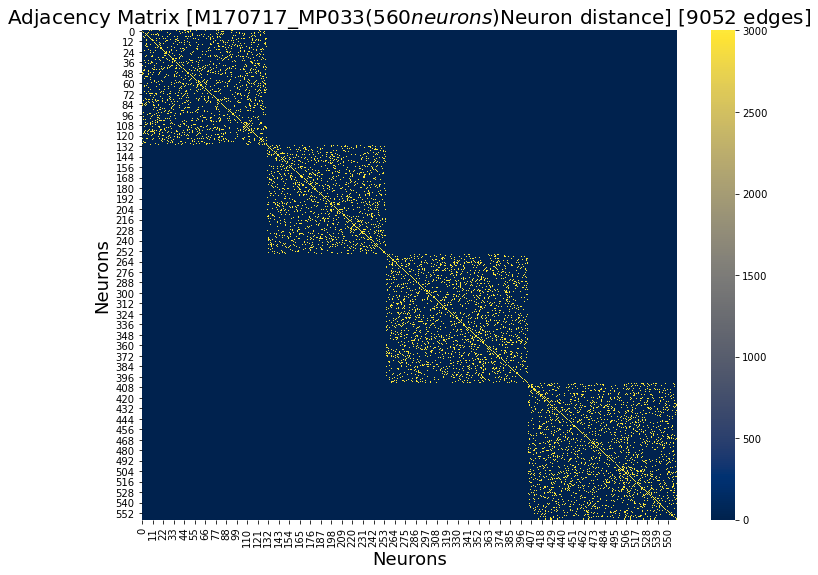

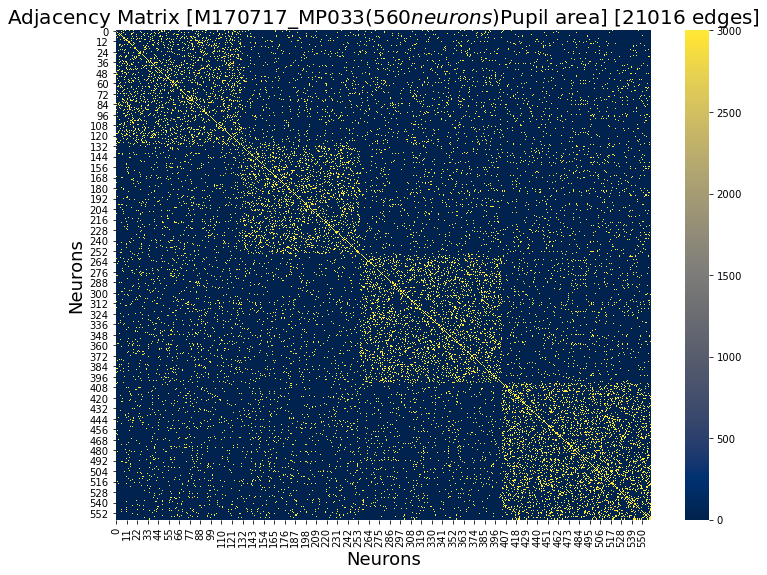

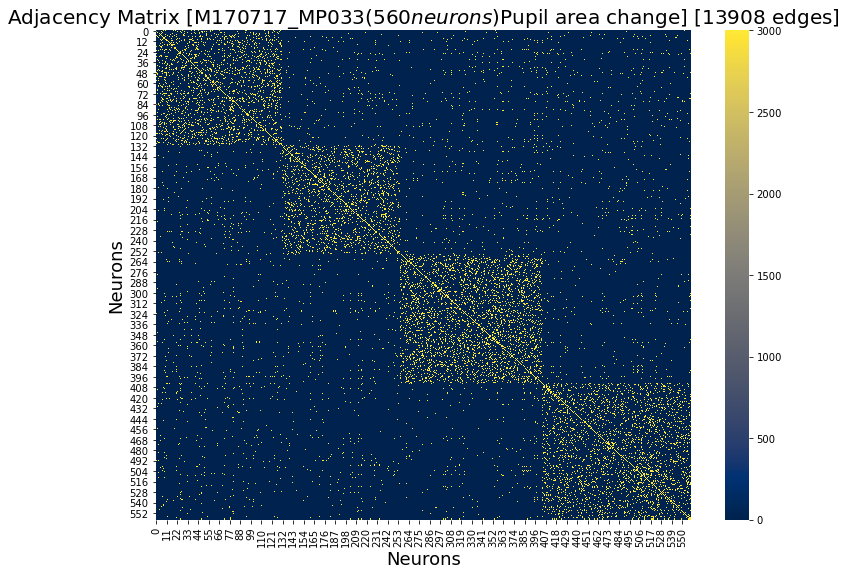

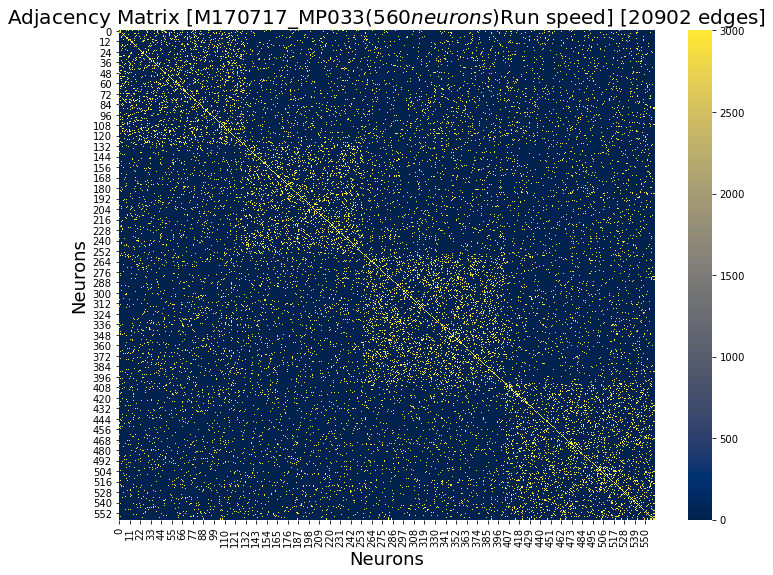

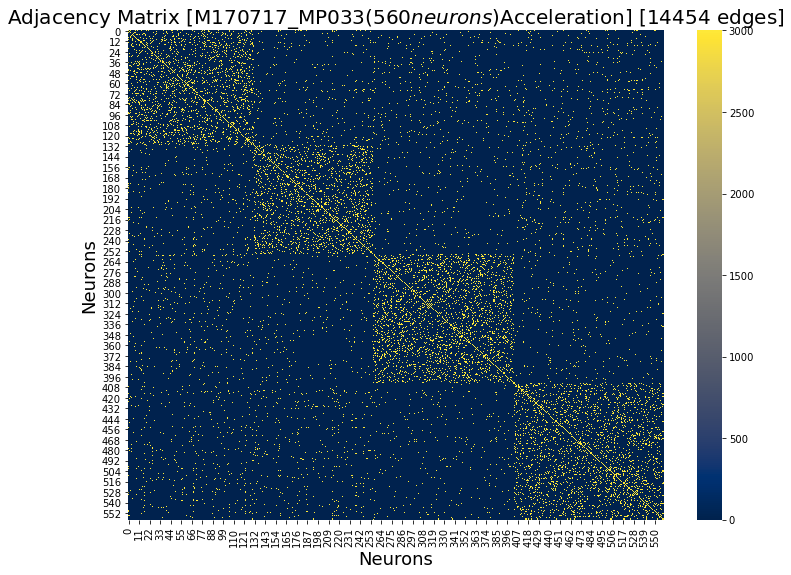

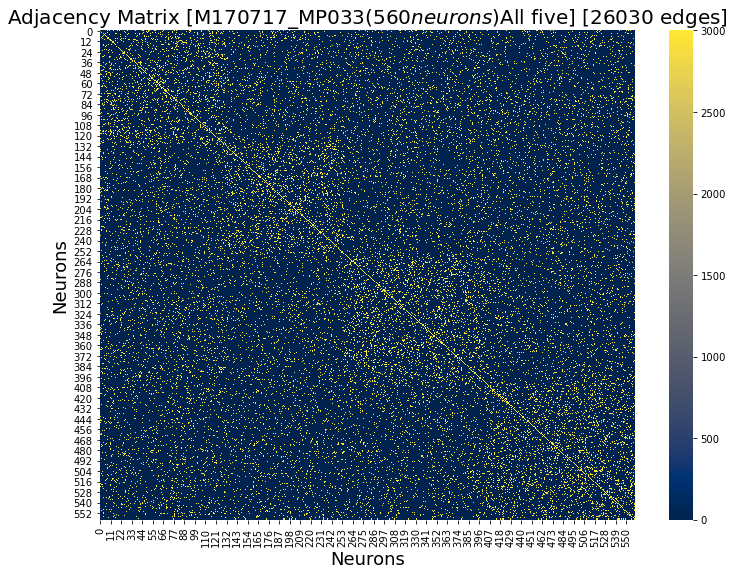

In [20]:
auxi_labels = ["Neuron distance", "Pupil area", "Pupil area change", "Run speed", "Acceleration", "All five"]
#auxi_labels = ["Neuron distance", "All five"]
putils.display_results_diff_auxi(auxi_labels, session2res_auxi)

In [21]:
fcr_config2 = FCRecoveryConfig(sessions=[7], time_range=(100, 1100), sim_timestamps=30, auxi_mask=None, 
                              layersOI=np.arange(4), xrange=(0.2, 0.6), yrange=(0.2, 0.6), 
                              sim_layer_size=2, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                              full_glasso_alpha=0.1, glasso_alpha=0.1, rec_model=glb.LINEAR_REG, 
                              edge_types=2, edge_cutoff_tol=1e-8)

In [22]:
session2res_auxi2 = diff_session_diff_auxi(fcr_config2, auxi_masks, consecutive=True)


9 datasets to loaded
Removing 4 zero-variance neurons

Session 7 loaded! M170717_MP033
start, end time:  100 1100


/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:211: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/utils.py:85: RuntimeWarning: Mean of empty slice
  avg_tuning_curve.append(np.nanmean(fsp_ibin, axis=1))


Session 7: Auxiliary Matrix Created!
Auxi_mats_to_use:  (1, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Auxi_mats_to_use:  (1, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Auxi_mats_to_use:  (1, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Auxi_mats_to_use:  (1, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Auxi_mats_to_use:  (1, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Auxi_mats_to_use:  (5, 560, 560)
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Session 7 Auxiliary Info Comparison Finished!



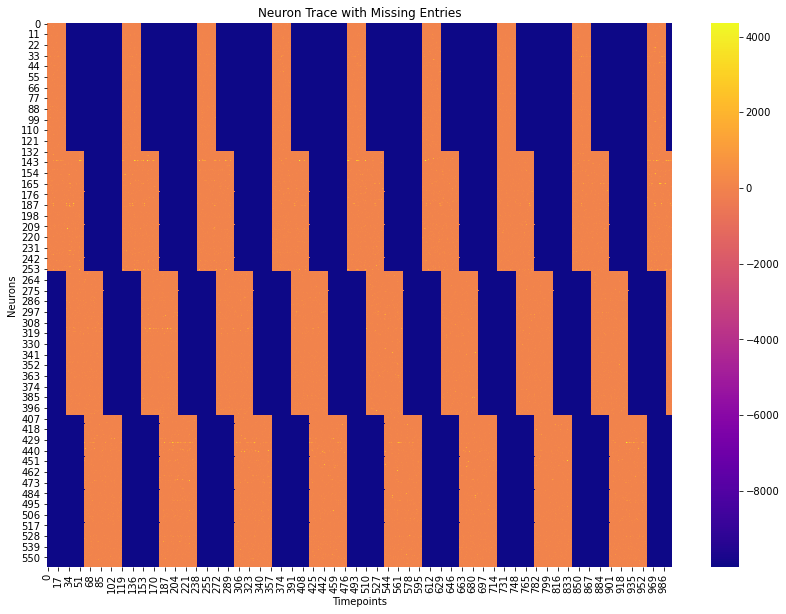

In [23]:
plt.rcParams['figure.figsize'] = [14, 10]
putils.display_missing_fsp(session2res_auxi2['M170717_MP033']['missing_fsp'])


Optimal Lambda for full data:  None


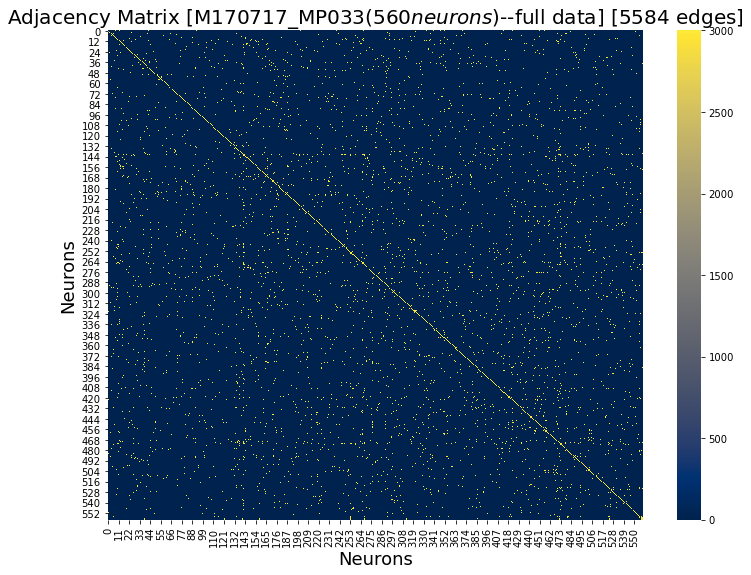

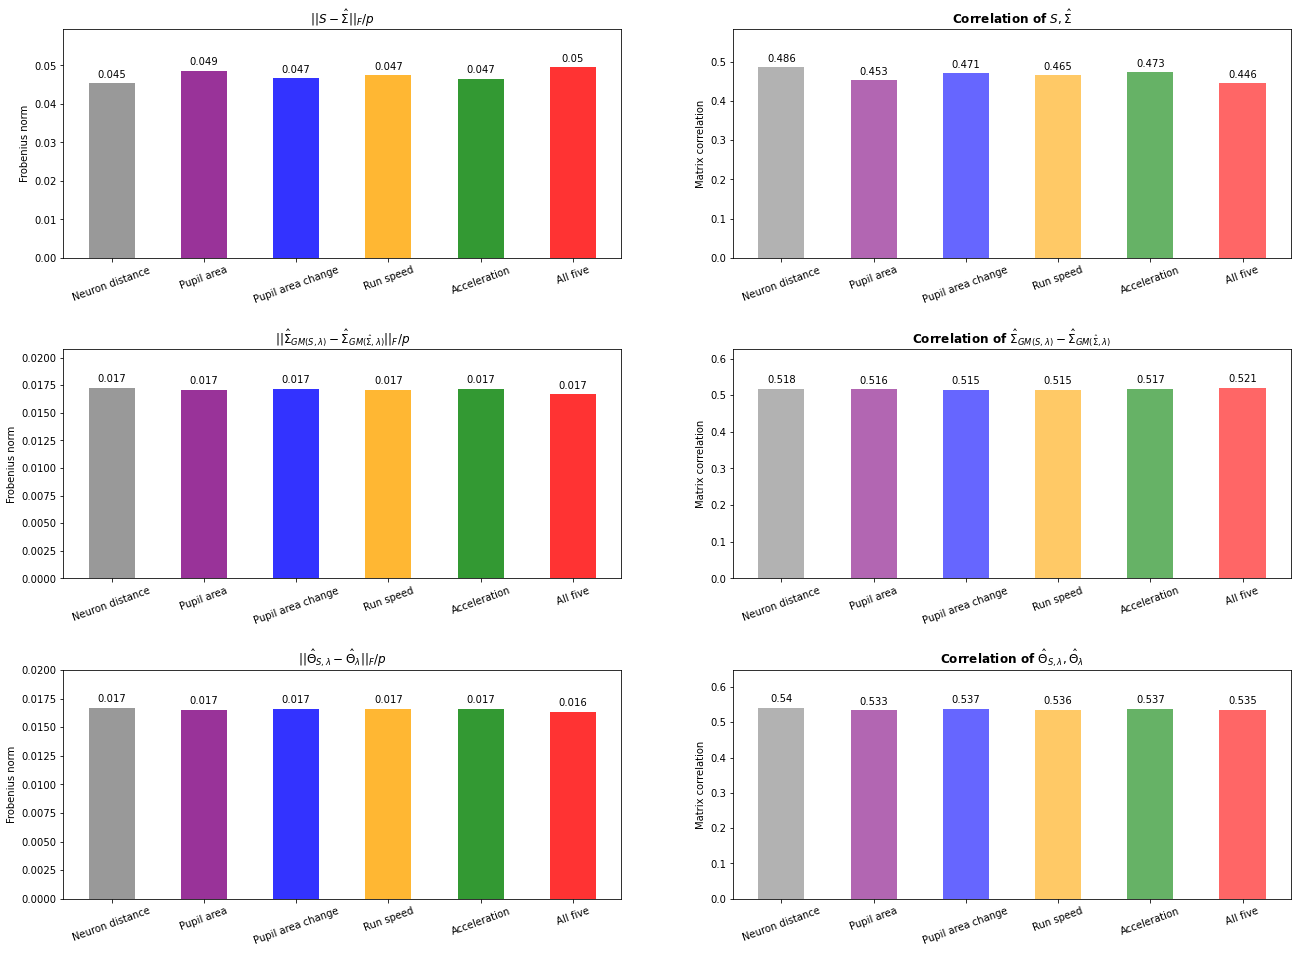

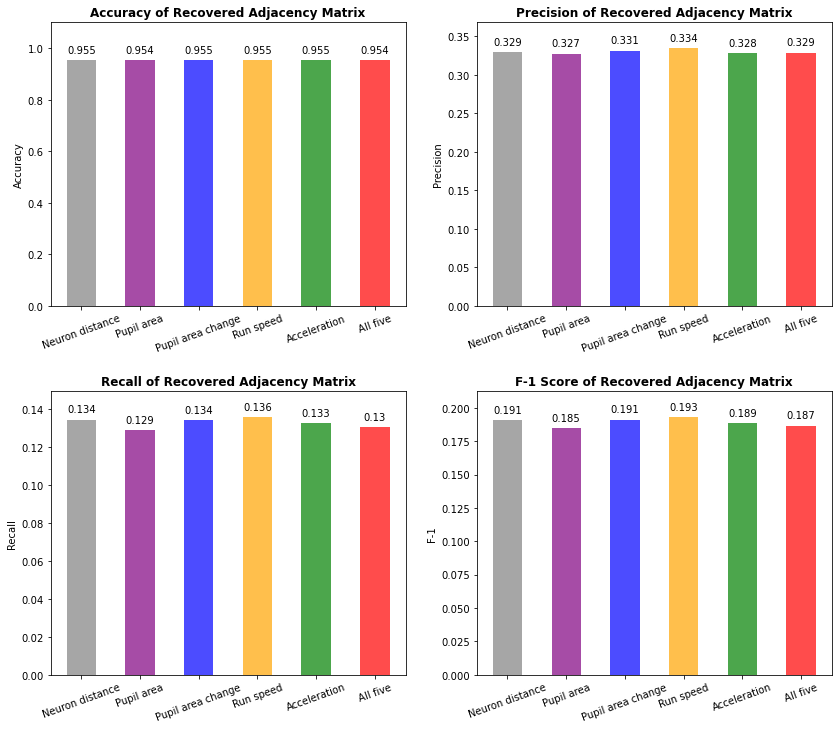

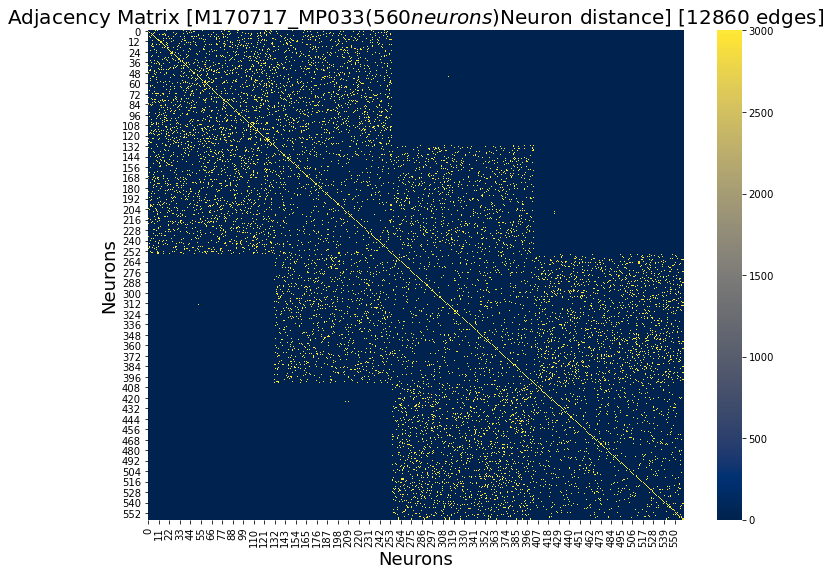

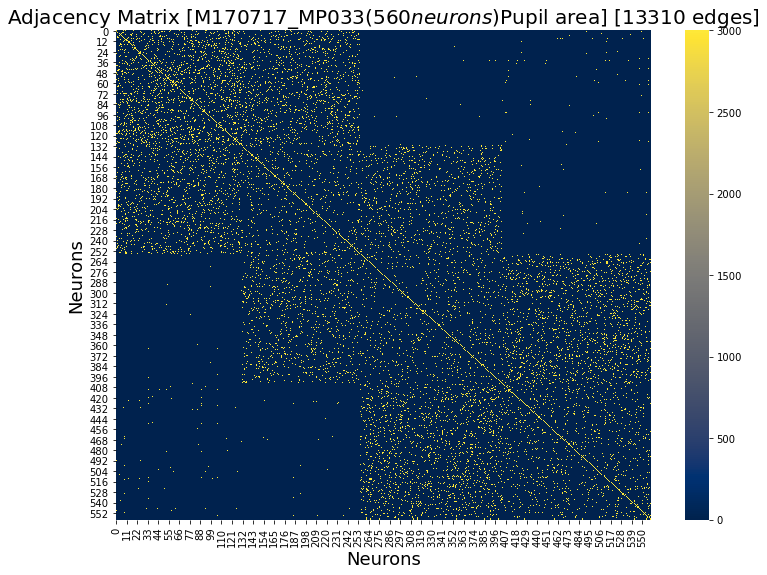

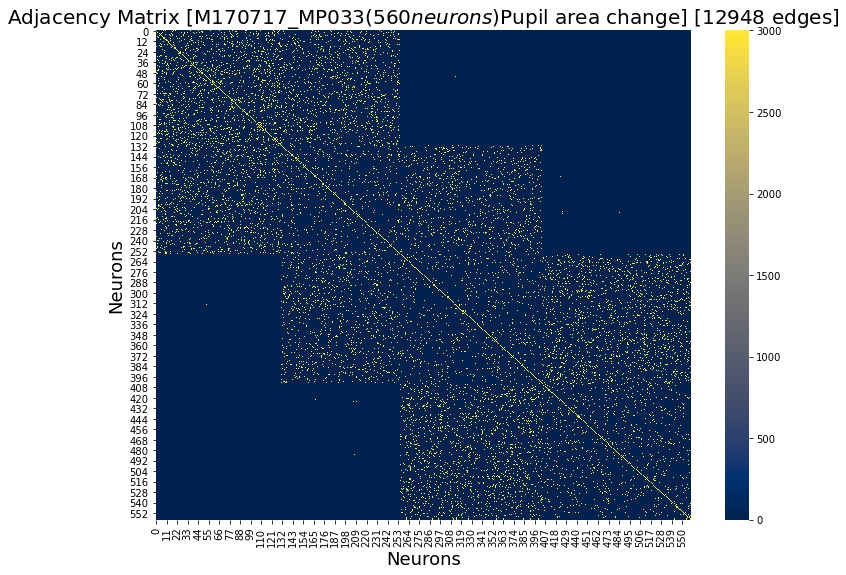

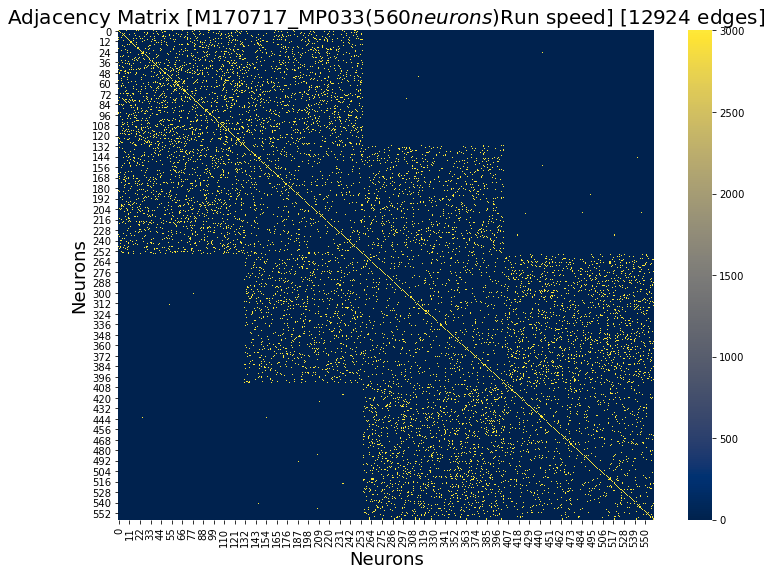

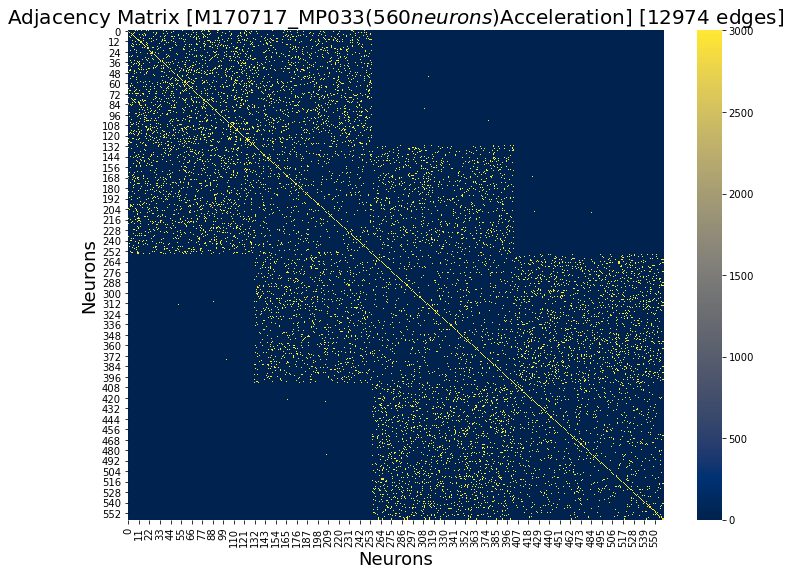

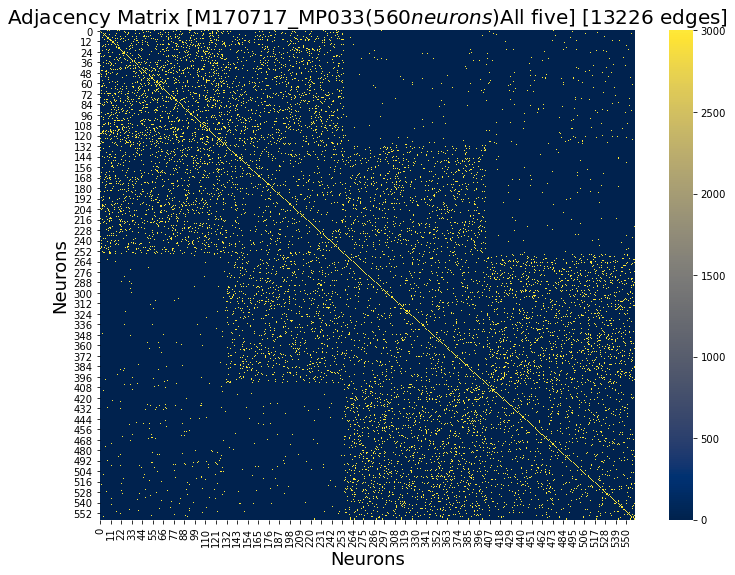

In [24]:
auxi_labels = ["Neuron distance", "Pupil area", "Pupil area change", "Run speed", "Acceleration", "All five"]
putils.display_results_diff_auxi(auxi_labels, session2res_auxi2)


### Interleaving layers within each simultaneous neuron blocks

In [25]:

fcr_config = FCRecoveryConfig(sessions=[1], time_range=(100, 1100), sim_timestamps=30, auxi_mask=None, 
                              layersOI=np.arange(4), xrange=(0.2, 0.6), yrange=(0.2, 0.6), 
                              sim_layer_size=1, layer_stride=1, psd_corrector=glb.ALT_PROJ,
                              full_glasso_alpha=0.1, glasso_alpha=0.1, rec_model=glb.LINEAR_REG, 
                              edge_types=2, edge_cutoff_tol=1e-8)


In [26]:
session2res_interleave = diff_session_diff_missing_by_layers(fcr_config, consecutive=False)


Total: 9 datasets
Removing 1 all-zero columns
Removing 7 zero-variance neurons

Session 1 loaded! M160907_MP028
Start, end time:  100 1100
Number of neurons:  735


/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:211: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers != 'all' and (max(layers) >= dataset.layer_counts or min(layers) < 0):
/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/data_sampler.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layers == 'all':


Sample Correlation Matrix is positive definite!


/Users/Mike/miniconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:261: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 6.304e-04
  warnings.warn('graphical_lasso: did not converge after '
/Users/Mike/Desktop/*ES201DecisionTheory/*Project/Recover_Functional_Connectivity/utils.py:85: RuntimeWarning: Mean of empty slice
  avg_tuning_curve.append(np.nanmean(fsp_ibin, axis=1))


Session 1: Auxiliary Matrix Created!
Final Correlation matrix contains NaN? False
Estimated sample covariance is not PSD, fixing with alt_proj method...
Session 1 Auxiliary Info Comparison Finished!



In [27]:
for k in session2res_interleave.keys():
    print("\n\nSession: %s" % k)
    print("Number of neurons: ", session2res_interleave[k]['missing_fsp'].shape[0])
    print(session2res_interleave[k]['result'])
    



Session: M160907_MP028
Number of neurons:  735
Ahat                 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
acc                  0.9036386216611986
auxi_sigma_corr      0.38222581470524736
auxi_sigma_err       0.07640716375657376
f1                   0.09849824853466514
fcRec_result         FCRecoveryResult(auxi_sigma=array([[ 1.        ,  0.03039377,  0.03530733, ..., -0.00609612,
        -0.02014541,  0.00737784],
       [ 0.03039377,  1.        ,  0.06225482, ...,  0.00140091,
        -0.02101754, -0.03111236],
       [ 0.03530733,  0.06225482,  1.        , ...,  0.04848271,
         0.03432367, -0.05968908],
       ...,
       [-0.00609612,  0.00140091,  0.04848271, ...,  1.        ,
         0.01774541,  0.00877529],
       [-0.02014541, -0.02101754,  0.03432367, ...,  0.01774541,
         1.        , -0.0138599 ],
       [ 0.00737784, -0.03111236, -0.05968908, ...